# <center>"Чётенькое такси"</center>
___
___

# <center>Самостоятельный проект по теме "Временные ряды"</center>
___
___

# <center>Описание проекта</center>
___
___

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.   

Количество заказов находится в столбце 'num_orders'.

# <center>Состав проекта</center>
___
___

<a id = 'back'></a>

[1. Загрузка и ресемплирование данных](#1)   
   
[2. Анализ данных](#2)   
   
[3. Обучение моделей](#3)   
   
[4. Проверка данных и выводы](#4)   

# <center>Ход работы</center>

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display
from ipywidgets import DatePicker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

<a id = '1'></a>
## 1. Загрузка и ресемплирование данных.
___

Считываем данные, устанавливаем индекс таблицы, равным столбцу `datetime`, смотрим общую информацию и что из себя пре

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = 'datetime')
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
print(taxi.head())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


Проверим расположены ли даты и время в хронологическом порядке. При необходимости отсортируем.

In [4]:
print(taxi.index.is_monotonic)

True


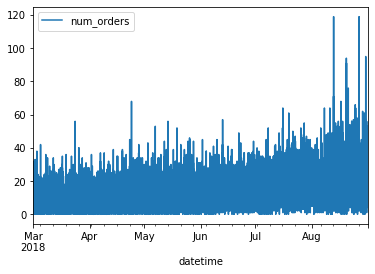

In [5]:
taxi.plot()

Все нормально. Займёмся ресемплированием по одному часу.

In [6]:
taxi = taxi.resample('1H').sum()

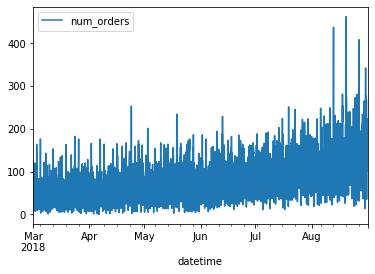

In [7]:
taxi.plot()

Мы изучили и немного подготовили предоставленные данные. Выполнили ресемплирование по одному часу и агрегировали значения функцией `sum()`. Эта агрегирующая функция была выбрана, так как исходные данные были рессемплированы с шагом в 10 минут, и проссумировав их для каждого часа - мы получаем фактическое количество заказов за этот час, что положительно отразится в дальнейшем на качестве предсказаний. Для сравнения данных до и после ресемплирования построили два графика, по ним еще сложно что-то конкретное сказать, однако изменения уже видны. Займёмся анализом данных.

___
[*к содержанию*](#back)

<a id = '2'></a>
## 2. Анализ данных
___

В первую очередь на графиках бросаются в глаза колебания. Чтобы "чище" анализировать данные применим скользящее среднее. В качестве размера окна предлагается взять значения в 2, 4, 6 и 8 часов, т.к. есть предположение, что тренды заказов такси связаны, помимо прочего, и с временем суток. Однако как слишком маленькое, так и слишком большое осреднение может исказить восприятие данных.

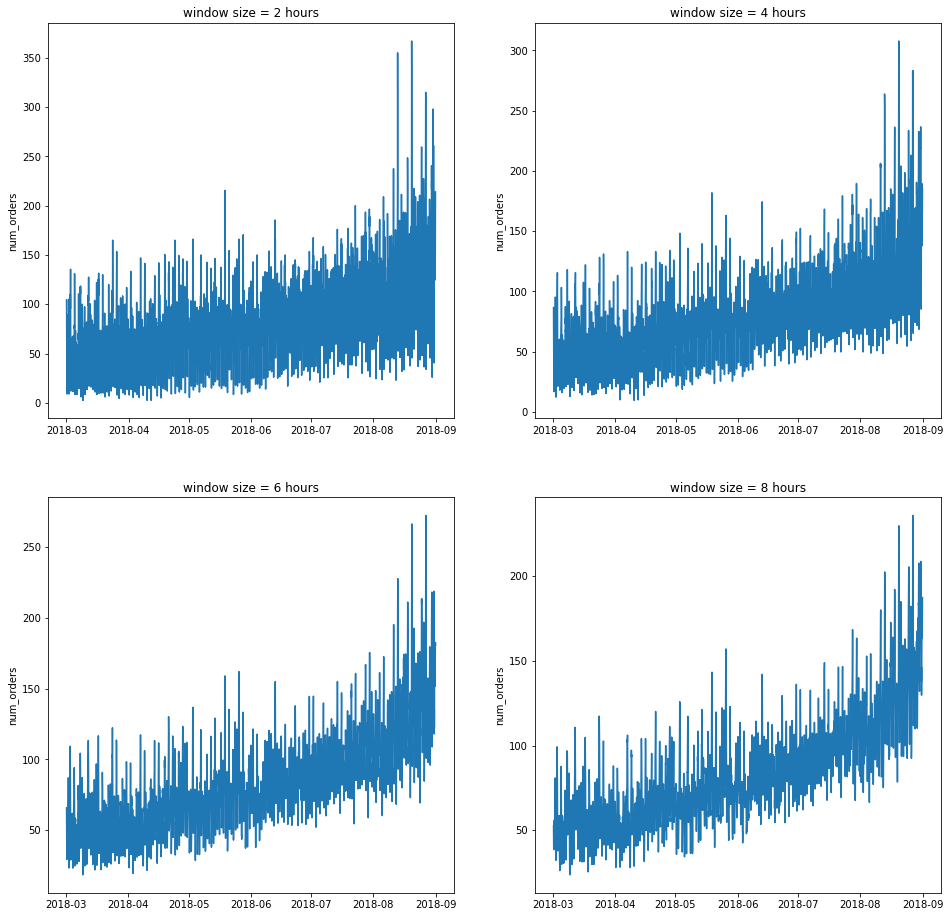

In [8]:
plt.figure(figsize = (16, 16))
plt.subplot(2,2,1)
plt.title('window size = 2 hours')
plt.ylabel('num_orders')
plt.plot(taxi.rolling(2).mean())
plt.subplot(2,2,2)
plt.title('window size = 4 hours')
plt.ylabel('num_orders')
plt.plot(taxi.rolling(4).mean())
plt.subplot(2,2,3)
plt.title('window size = 6 hours')
plt.ylabel('num_orders')
plt.plot(taxi.rolling(6).mean())
plt.subplot(2,2,4)
plt.title('window size = 8 hours')
plt.ylabel('num_orders')
plt.plot(taxi.rolling(8).mean())

Нельзя сказать, что выбранные размеры окна осреднения сильно помогли, однако при 6-ти и 8-ми часовых окнах уже прослеживаются хоть какие-то тренды. В качестве теста попробуем ещё окно в 12 и в 24 часа.

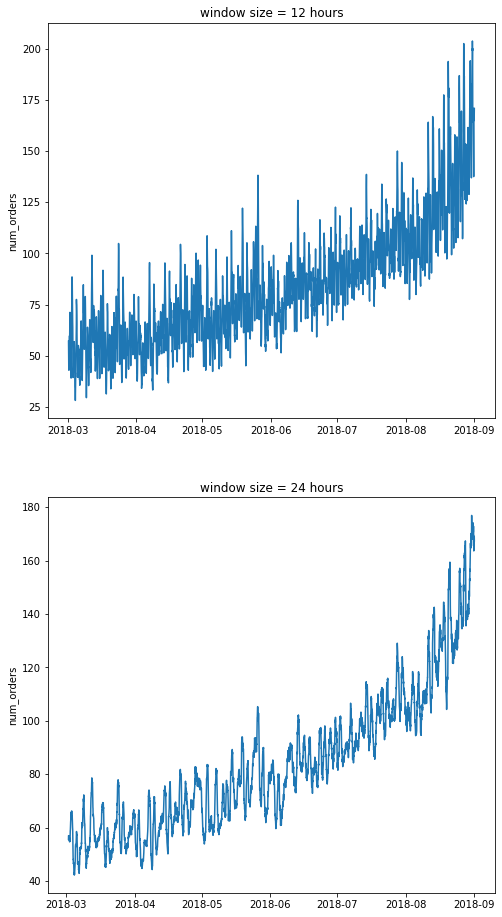

In [9]:
plt.figure(figsize = (8, 16))
plt.subplot(2,1,1)
plt.title('window size = 12 hours')
plt.ylabel('num_orders')
plt.plot(taxi.rolling(12).mean())
plt.subplot(2,1,2)
plt.title('window size = 24 hours')
plt.ylabel('num_orders')
plt.plot(taxi.rolling(24).mean())

Теперь характер распределения более понятен. Добавим пока скользящее среднее в отдельную колонку с данными и посмотрим на итоговую картину. Однако на данном этапе стоит отметить, что так как перед нами стоит задача предксказания количества заказов такси на следующий час - возможно нам придется сузить окно до 12 или даже 8 часов, так как сейчас мы рассмотрели суточное "поведение" данных на всем их диапазоне, однако по исходным данным видны изменения трендов в зависимости от времени года.

In [10]:
#taxi['rolling_mean'] = taxi.rolling(24).mean()
#taxi.plot()

Так как у нас представлены данные только за пол года - сезонность мы определить не можем, однако тренды - вполне. Займёмся этим.

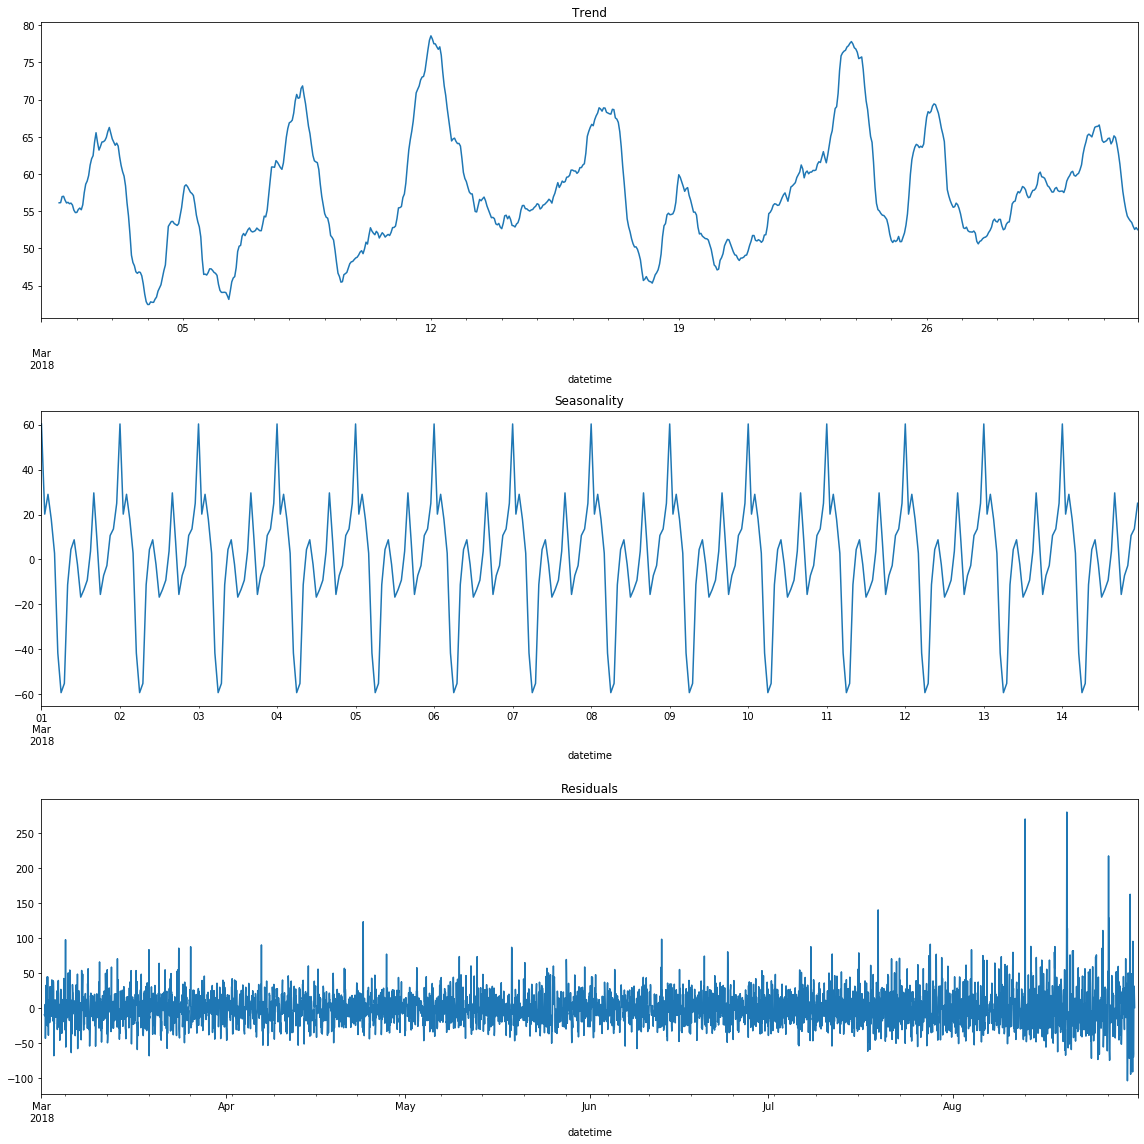

In [11]:
decomposed_taxi = seasonal_decompose(taxi)
plt.figure(figsize=(16, 16))
plt.subplot(311)
decomposed_taxi.trend['2018-03'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_taxi.seasonal['2018-03-01':'2018-03-14'].plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_taxi.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [12]:
dPicker = DatePicker(
    description='Дата:'
)

display(dPicker)

DatePicker(value=None, description='Дата:')

Если рассматривать весь набор данных - тренд связан с временем года: к концу лета количество заказов такси повышается. Связано это определенно с повышенной активностью, в частности - уличной, гражан в это время: возвращение из отпусков, последние ледние шашлыки, подготовка детей к школе и т.д. Если рассмотреть данные за месяц - тренд связан с днем недели: основные пики заказов приходятся на дни с пятницы по воскресенье, что логично - так как выходные, отдых и т.д.   
Поговорим о сезонности. При её рассмотрении на всем наборе данных какие-то выводы делать сложно, поэтому рассмотрели данные за первые 15 дней марта. Выше специально был добавлен календарь, с помощью которого мы увидели что 2 марта 2018 года - пятница. Была теория что количество заказов зависит от дня недели, однако сезонность изо дня в день повторяется (даже если ее рассмотреть в масштабе месяца). Однако при анализе сезонности в течение дня картина более ясная: с раннего утра (5:00 - 7:00) провал по заказам, пик же приходится всегда на конец дня.

Text(0.5, 1.0, 'Day_Seasonality')

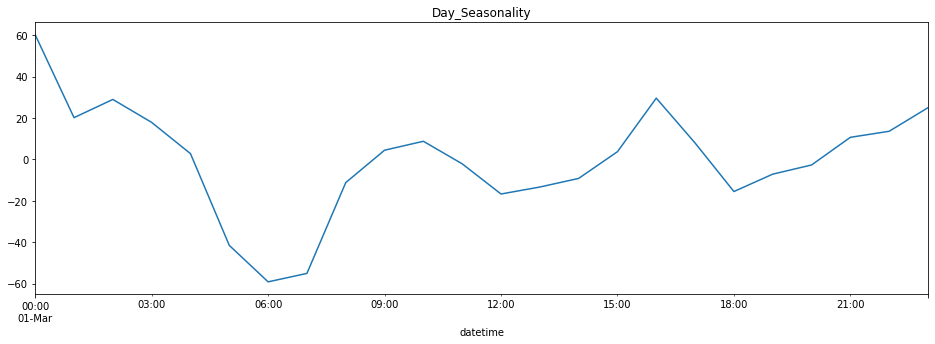

In [13]:
plt.figure(figsize=(16, 5))
decomposed_taxi.seasonal['2018-03-01'].plot(ax = plt.gca())
plt.title('Day_Seasonality')

Построим график скользящего стандартного отклонения.

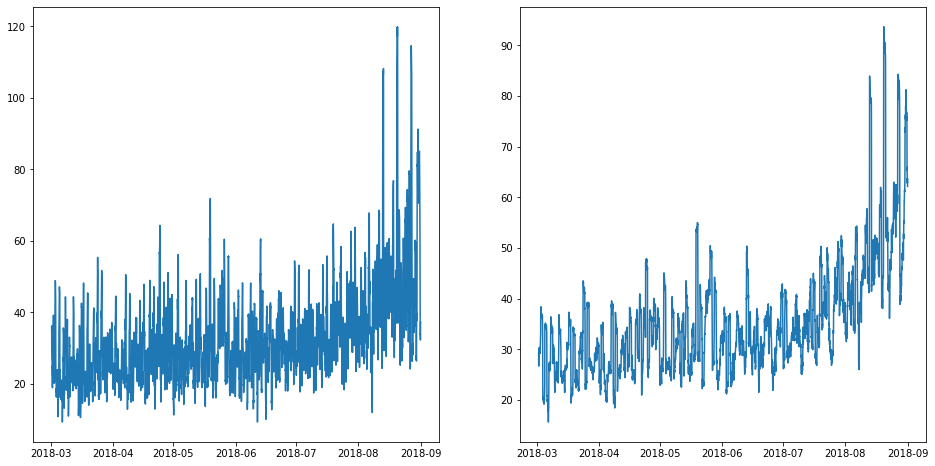

In [14]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(taxi.rolling(12).std())
plt.subplot(122)
plt.plot(taxi.rolling(24).std())

В принципе пока не важен размер окна для скользящего стандартного отклонения: по обоим графикам видно, что оно отклонение меняется.   
По итогу можно сказать что мы имее дело с нестационарным временным рядом. Нестационарные ряды прогнозировать сложнее: их свойства меняются слишком быстро. В связи с этим необходимо сделать ряд более стационарным, воспользовавшись разностями временного ряда.

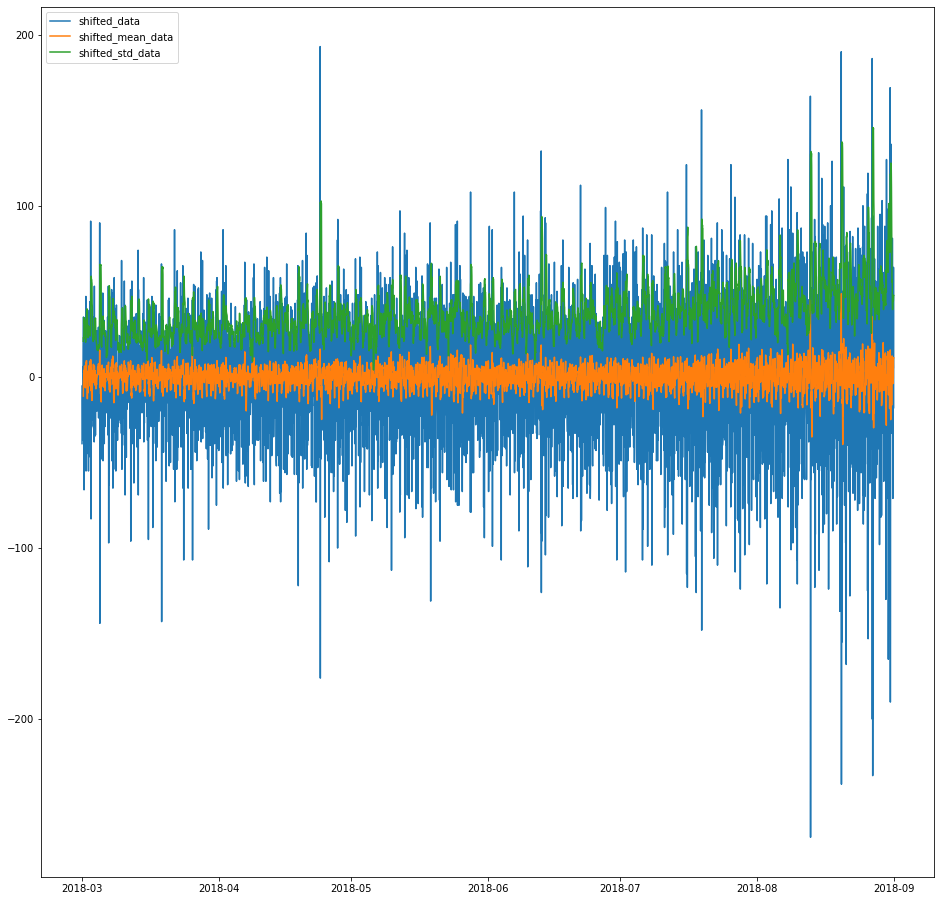

In [15]:
plt.figure(figsize=(16, 16))
plt.plot((taxi - taxi.shift()), label = 'shifted_data')
plt.plot((taxi - taxi.shift()).rolling(8).mean(), label = 'shifted_mean_data')
plt.plot((taxi - taxi.shift()).rolling(8).std(), label = 'shifted_std_data')
plt.legend()

Ряд стал более стационарным, теперь его легче прогнозировать. Перейдем к обучению моделей.

___
[*к содержанию*](#back)

<a id = '3'></a>
## 3. Обучение моделей
___

Итак, мы имеем дело с задачей регрессии для временных рядов.   
Необходимо заняться подготовкой данных:   
- во-первых, перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего.   
- во-вторых, по заданию нам необходимо 10% исходных данных отложить для тестовой выборки, но кроме того нам нужна валидационная выборка для перебора гиперпараметров, для неё тоже возьмем 10%.

Сначала займёмся созданием признаков. Напишем для этого функцию, чтобы была возможность быстро пересоздать датафрейм для обучения. В качестве признаков, исходя из анализа данных, будут выступать:   
- календарные признаки: месяц, день недели и час в сутках;   
- отстающие значения;   
- скользящее среднее.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [17]:
make_features(taxi, 27, 24)
display(taxi.head())

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,56.958333
2018-03-02 05:00:00,11,4,5,20.0,64.0,75.0,120.0,90.0,58.0,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.000000
2018-03-02 06:00:00,11,4,6,11.0,20.0,64.0,75.0,120.0,90.0,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,56.208333
2018-03-02 07:00:00,7,4,7,11.0,11.0,20.0,64.0,75.0,120.0,90.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.166667


Получили набор признаков для вычисления целевого. Разделим полученные данные на выборки.

In [18]:
train, temp = train_test_split(taxi, shuffle=False, test_size=0.2)
valid, test = train_test_split(temp, shuffle=False, test_size=0.5)
print(train.shape, valid.shape, test.shape)

(3511, 31) (439, 31) (439, 31)


In [19]:
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']
features_valid = valid.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis = 1)

Обучим три модели. В качестве подопытных выбраны `LinearRegression`, `GradientBoostingRegressor` и `RandomForestRegression`.

### LinearRegression

In [20]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
lr_pred = lr_model.predict(features_valid)
print(mean_squared_error(target_valid, lr_pred, squared = False))

34.31042998607008


На валидационной выборке довольно неплохое значение метрики. Посмотрим потом что она покажет на тестовой. В модели `LinearRegression` не особо много гиперпараметров, чтобы с ними баловаться, так что оставим их по умолчанию а основное внимание уделим оставшимся двум моделям.

### GradientBoostingRegressor

In [21]:
gbr_model = GradientBoostingRegressor(random_state = 481516, loss = 'quantile', max_depth = 7, n_estimators = 115, subsample = 0.7)
gbr_model.fit(features_train, target_train)
gbr_pred = gbr_model.predict(features_valid)
print(mean_squared_error(target_valid, gbr_pred, squared = False))

36.2631581804265


Значение метрики довольно неплохое. Но теперь надо заняться подбором гиперпараметров. По классике будем перебирать такие гиперпараметры как `n_estimators` и `max_depth`, а так как они присутствуют у обоих оставшихся моделей - создадим один набор.

In [22]:
params = {
    'n_estimators' : range (100, 201, 50),
    'max_depth' : range (3, 21, 2)
}

In [23]:
#grid_gbr_model = GridSearchCV(gbr_model, params, scoring = 'neg_root_mean_squared_error')
#grid_gbr_model.fit(features_train, target_train)

In [24]:
#grid_gbr_model.best_params_

Для данной модели в качестве лучших получили следующие гиперпараметры: {'max_depth': 5, 'n_estimators': 100}. Далее код по их подбору закомментируем, чтобы не тратить на него время при перезапуске блокнота.

### RandomForestRegression

In [25]:
rfr_model = RandomForestRegressor(random_state = 481516, max_depth = 19, n_estimators = 100)
rfr_model.fit(features_train, target_train)
rfr_pred = rfr_model.predict(features_valid)
print(mean_squared_error(target_valid, rfr_pred, squared = False))

32.265691738560264


Значение метрики довольно неплохое. Подберем гиперпараметры гиперпараметры.

In [26]:
#grid_rfr_model = GridSearchCV(rfr_model, params, scoring = 'neg_root_mean_squared_error')
#grid_rfr_model.fit(features_train, target_train)

In [27]:
#grid_rfr_model.best_params_

Для данной модели в качестве лучших получили следующие гиперпараметры: {'max_depth': 19, 'n_estimators': 100}. Далее код по их подбору закомментируем, чтобы не тратить на него время при перезапуске блокнота.

Чтож, мы получили три модели, для двух из которых подобраны гиперпараметры. Проверим их на тестовых выборках и сделаем выводы.

___
[*к содержанию*](#back)

<a id = '4'></a>
## 4. Проверка данных и выводы
___

Получим предсказания и значения метрики `RMSE` для каждой из моделей.

In [28]:
lr_pred = lr_model.predict(features_test)
lr_rmse = mean_squared_error(target_test, lr_pred, squared = False)
gbr_pred = gbr_model.predict(features_test)
gbr_rmse = mean_squared_error(target_test, gbr_pred, squared = False)
rfr_pred = rfr_model.predict(features_test)
rfr_rmse = mean_squared_error(target_test, rfr_pred, squared = False)

In [29]:
print('RMSE для линейной регрессии: {:.2f} \nRMSE для градиентного бустинга: {:.2f} \nRMSE для случайного леса: {:.2f}'
      .format(lr_rmse, gbr_rmse, rfr_rmse))

RMSE для линейной регрессии: 45.74 
RMSE для градиентного бустинга: 47.19 
RMSE для случайного леса: 48.86


Таким образом мы получили адекватные предсказания двумя моделями.   
Стоит отметить, что помимо подбора наилучших гиперпараметров рассматриваемых моделей - перебирались агрументы функции создания признаков, таким образом их так же можно рассматривать, как своего рода гиперпараметры.

In [30]:
lr_data = pd.DataFrame(lr_pred).set_index(target_test.index)
gbr_data = pd.DataFrame(gbr_pred).set_index(target_test.index)
rfr_data = pd.DataFrame(rfr_pred).set_index(target_test.index)

Text(0, 0.5, 'order_count')

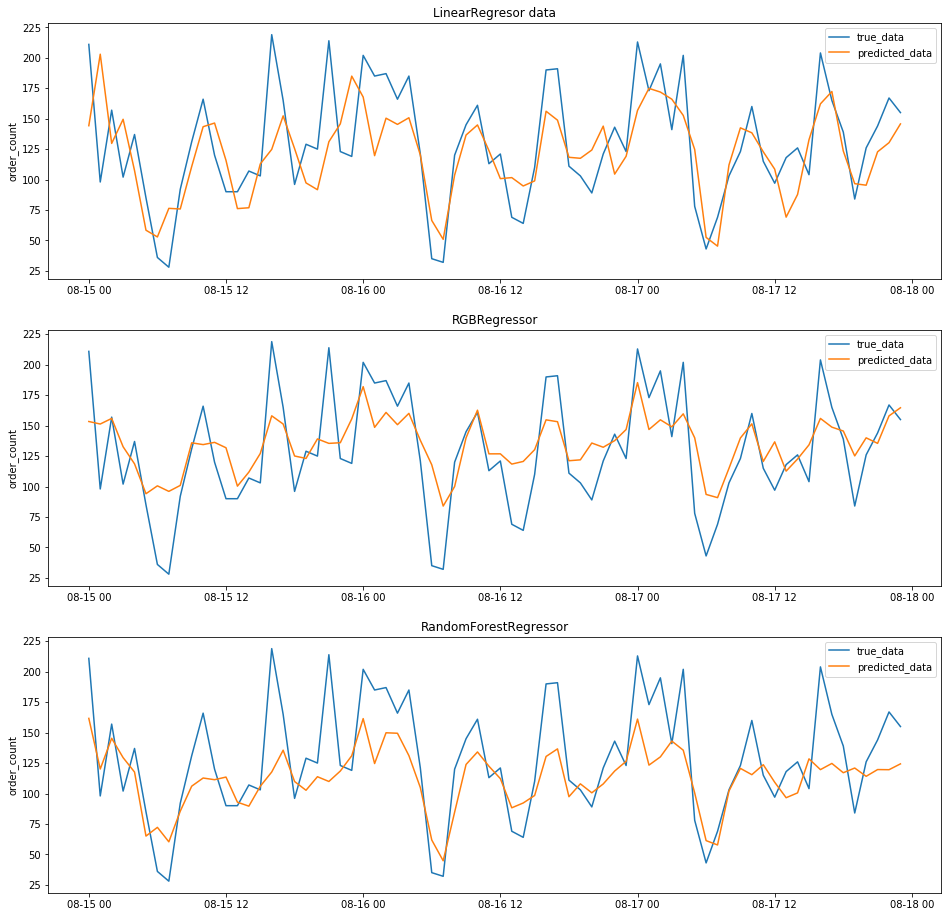

In [31]:
tstart = '2018-08-15'
tend = '2018-08-17'
plt.figure(figsize = (16, 16))
plt.subplot(311)
plt.plot(target_test[tstart:tend], label = 'true_data')
plt.plot(lr_data[tstart:tend], label = 'predicted_data')
plt.legend()
plt.title('LinearRegresor data')
plt.ylabel('order_count')
plt.subplot(312)
plt.plot(target_test[tstart:tend], label = 'true_data')
plt.plot(gbr_data[tstart:tend], label = 'predicted_data')
plt.legend()
plt.title('RGBRegressor')
plt.ylabel('order_count')
plt.subplot(313)
plt.plot(target_test[tstart:tend], label = 'true_data')
plt.plot(rfr_data[tstart:tend], label = 'predicted_data')
plt.legend()
plt.title('RandomForestRegressor')
plt.ylabel('order_count')

___
[*к содержанию*](#back)